In [7]:
import devito
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


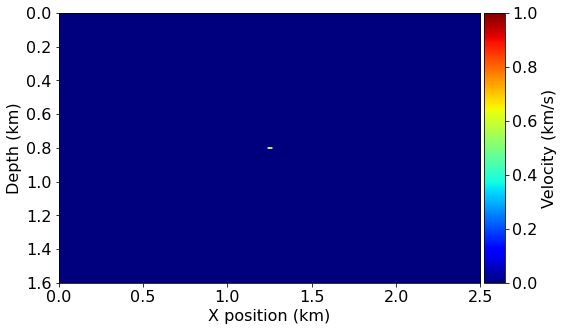

In [14]:
from examples.seismic import Model, plot_velocity

shape = (101, 201)
spacing = (25,8)
origin = (0., 0.)

vel = np.zeros(shape, dtype=np.float32)
vel[shape[0]//2, shape[1]//2] = 1.

model = Model(vp=vel, origin=origin, shape=shape, spacing=spacing, space_order=2, nbl=20, bcs="damp")
plot_velocity(model)

In [15]:
help(Model)

Help on class SeismicModel in module examples.seismic.model:

class SeismicModel(GenericModel)
 |  SeismicModel(origin, spacing, shape, space_order, vp, nbl=20, fs=False, dtype=<class 'numpy.float32'>, subdomains=(), bcs='mask', grid=None, **kwargs)
 |  
 |  The physical model used in seismic inversion processes.
 |  
 |  Parameters
 |  ----------
 |  origin : tuple of floats
 |      Origin of the model in m as a tuple in (x,y,z) order.
 |  spacing : tuple of floats
 |      Grid size in m as a Tuple in (x,y,z) order.
 |  shape : tuple of int
 |      Number of grid points size in (x,y,z) order.
 |  space_order : int
 |      Order of the spatial stencil discretisation.
 |  vp : array_like or float
 |      Velocity in km/s.
 |  nbl : int, optional
 |      The number of absorbin layers for boundary damping.
 |  bcs: str or callable
 |      Absorbing boundary type ("damp" or "mask") or initializer.
 |  dtype : np.float32 or np.float64
 |      Defaults to np.float32.
 |  epsilon : array_like

In [16]:
from examples.seismic import TimeAxis

t0 = 0.
tn = 1000.
dt = model.critical_dt

time_range = TimeAxis (start=t0, stop=tn, step=dt)

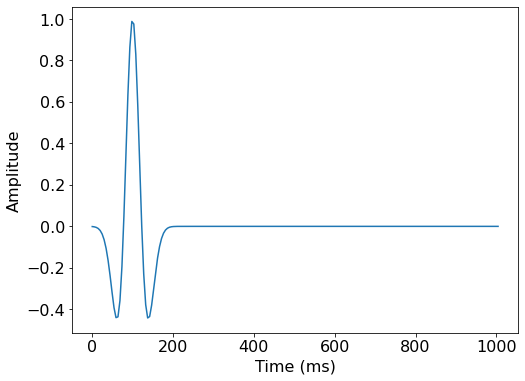

In [20]:
from examples.seismic import RickerSource

f0 = 0.010
src = RickerSource(name='src', grid=model.grid, f0=f0,
                  npoint=1, time_range=time_range)

src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 20.

src.show()

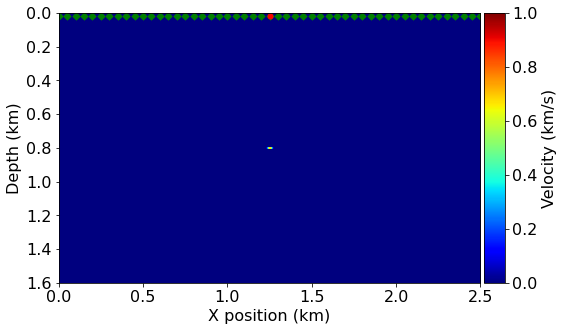

In [25]:
from examples.seismic import Receiver

rec = Receiver(name='rec', grid=model.grid, npoint=201, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:,0] = np.linspace(0, model.domain_size[0], num=201)
rec.coordinates.data[:,1] = 20.

plot_velocity(model, source=src.coordinates.data,
             receiver=rec.coordinates.data[::4, :])

In [34]:
from devito import TimeFunction

u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

pde

damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [35]:
from devito import Eq, solve

stencil = Eq(u.forward, solve(pde, u.forward))
stencil

Eq(u(t + dt, x, y), (-(-2.0*u(t, x, y)/dt**2 + u(t - dt, x, y)/dt**2)/vp(x, y)**2 + Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + damp(x, y)*u(t, x, y)/dt)/(damp(x, y)/dt + 1/(dt**2*vp(x, y)**2)))